In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Instalando as bibliotecas necessárias

In [2]:
!pip install feature-engine lightgbm xgboost catboost

## Carregando o conjunto de dados e separando em treino e oot

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os

WORK_DIR = '/content/drive/My Drive/datasets'
DATA_DIR = os.path.join(WORK_DIR, 'olist')
df_abt = pd.read_csv(os.path.join(DATA_DIR, 'propensao_revenda_abt.csv'))

# pega a base de treinamento
df_train = df_abt.query('data_ref_safra < "2018-03-01"')

# pega a base de avaliação (out of time)
df_oot   = df_abt.query('data_ref_safra == "2018-03-01"')

key_vars = ['data_ref_safra', 'seller_id']
num_vars = ['tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m', 'recencia']
cat_vars = ['uf']
target = 'nao_revendeu_next_6m'

features = cat_vars + num_vars

# dados de treinamento
X_train = df_train[features]
y_train = df_train[target]

# dados de avaliação (out of time)
X_oot = df_oot[features]
y_oot = df_oot[target]

## Carregando os pacotes

In [4]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline

from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

## Treinando

In [5]:
steps_em_comum = [
    ('numeric_imputer', MeanMedianImputer(variables=num_vars, imputation_method='median')),
    ('categoric_imputer', CategoricalImputer(variables=cat_vars)),
    ('one_hot_encoder', OneHotEncoder(variables=cat_vars))
]

steps_exclusivos_lineares = [
    ('numeric_scaler', SklearnTransformerWrapper(variables=num_vars, transformer=StandardScaler()))
]

random_state=42

In [6]:
algoritmos = {
    'linear': [
        ('logistic_regression', LogisticRegression(random_state=random_state))
    ],
    'tree': [
        ('dt', DecisionTreeClassifier(random_state=random_state)),
        ('random_forest', RandomForestClassifier(random_state=random_state)),
        ('xgb', XGBClassifier(random_state=random_state)),
        ('lgbm', LGBMClassifier(random_state=random_state, verbose=0)),
        ('catboost', CatBoostClassifier(random_state=random_state, verbose=0))
    ]
}

In [7]:
import pandas as pd

df = pd.DataFrame(columns=['acc', 'precision', 'recall', 'f1', 'roc_auc'])

for type_algorithms, algorithms in algoritmos.items():
    if type_algorithms == 'linear':
        steps = steps_em_comum + steps_exclusivos_lineares
    elif type_algorithms == 'tree':
        steps = steps_em_comum

    for alg in algorithms:
        nome = alg[0]
        print(f'Treinando o algoritmo {nome}', end=' ... ')
        model_pipe = Pipeline(steps=steps + [alg])
        result_cv = cross_validate(estimator=model_pipe, X=X_train, y=y_train, cv=5, scoring=['accuracy','precision', 'recall', 'f1', 'roc_auc'])
        s = pd.DataFrame(result_cv).mean()
        df.loc[nome] = [
            s['test_accuracy'],
            s['test_precision'],
            s['test_recall'],
            s['test_f1'],
            s['test_roc_auc']
        ]
        print('OK!')

Treinando o algoritmo logistic_regression ... OK!
Treinando o algoritmo dt ... OK!
Treinando o algoritmo random_forest ... OK!
Treinando o algoritmo xgb ... OK!
Treinando o algoritmo lgbm ... OK!
Treinando o algoritmo catboost ... OK!


In [8]:
df.sort_values('roc_auc', ascending=False)

,acc,precision,recall,f1,roc_auc
random_forest,0.849785,0.820002,0.776317,0.797345,0.921442
xgb,0.848069,0.811067,0.783844,0.796977,0.918795
catboost,0.846352,0.808868,0.782329,0.795135,0.917996
lgbm,0.846638,0.805871,0.787564,0.796514,0.915869
logistic_regression,0.826037,0.851009,0.659182,0.742606,0.897631
dt,0.784263,0.717559,0.718496,0.717694,0.771632


## Avaliando ba base OOT

In [9]:
# Melhor modelo foi o Catboost, logo:

melhor_modelo = Pipeline(steps=steps_em_comum + [('random_forest', RandomForestClassifier(random_state=random_state))])
melhor_modelo

Pipeline(steps=[('numeric_imputer',
                 MeanMedianImputer(variables=['tot_orders_12m', 'tot_items_12m',
                                              'tot_items_dist_12m',
                                              'receita_12m', 'recencia'])),
                ('categoric_imputer', CategoricalImputer(variables=['uf'])),
                ('one_hot_encoder', OneHotEncoder(variables=['uf'])),
                ('random_forest', RandomForestClassifier(random_state=42))])

In [10]:
melhor_modelo.fit(X_train, y_train)

Pipeline(steps=[('numeric_imputer',
                 MeanMedianImputer(variables=['tot_orders_12m', 'tot_items_12m',
                                              'tot_items_dist_12m',
                                              'receita_12m', 'recencia'])),
                ('categoric_imputer', CategoricalImputer(variables=['uf'])),
                ('one_hot_encoder', OneHotEncoder(variables=['uf'])),
                ('random_forest', RandomForestClassifier(random_state=42))])

In [11]:
y_pred_oot = melhor_modelo.predict(X_oot)

In [12]:
y_proba_oot = melhor_modelo.predict_proba(X_oot)[:,1]

In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_oot = roc_auc_score(y_oot, y_proba_oot)
print(f'RoC-AUC: {roc_auc_oot:.6f}')

RoC-AUC: 0.922921


## Otimização dos hiperparâmetros

In [14]:
melhor_modelo

Pipeline(steps=[('numeric_imputer',
                 MeanMedianImputer(variables=['tot_orders_12m', 'tot_items_12m',
                                              'tot_items_dist_12m',
                                              'receita_12m', 'recencia'])),
                ('categoric_imputer', CategoricalImputer(variables=['uf'])),
                ('one_hot_encoder', OneHotEncoder(variables=['uf'])),
                ('random_forest', RandomForestClassifier(random_state=42))])

In [15]:
# Demora aproximadamente XX de minutos
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'random_forest__n_estimators': [50, 150, 300],
    'random_forest__max_depth': [5, 8, 15],
    'random_forest__max_features': ['log2', 'sqrt'],
    'random_forest__class_weight': ['balanced', None]
}

melhor_modelo_otimizado = RandomizedSearchCV(melhor_modelo, parameters, scoring='roc_auc', cv=3, n_iter=30, n_jobs=-1, verbose=1, random_state=42)

melhor_modelo_otimizado.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('numeric_imputer',
                                              MeanMedianImputer(variables=['tot_orders_12m',
                                                                           'tot_items_12m',
                                                                           'tot_items_dist_12m',
                                                                           'receita_12m',
                                                                           'recencia'])),
                                             ('categoric_imputer',
                                              CategoricalImputer(variables=['uf'])),
                                             ('one_hot_encoder',
                                              OneHotEncoder(variables=['uf'])),
                                             ('random_forest',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'random_forest__class_weight': ['balanced',
                                                                        None],
                                        'random_forest__max_depth': [5, 8, 15],
                                        'random_forest__max_features': ['log2',
                                                                        'sqrt'],
                                        'random_forest__n_estimators': [50, 150,
                                                                        300]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [16]:
y_proba_oot = melhor_modelo_otimizado.predict_proba(X_oot)[:,1]

In [17]:
roc_auc_oot = roc_auc_score(y_oot, y_proba_oot)
print(f'RoC-AUC: {roc_auc_oot:.6f}')

RoC-AUC: 0.926182


In [18]:
melhor_modelo_otimizado.best_estimator_

Pipeline(steps=[('numeric_imputer',
                 MeanMedianImputer(variables=['tot_orders_12m', 'tot_items_12m',
                                              'tot_items_dist_12m',
                                              'receita_12m', 'recencia'])),
                ('categoric_imputer', CategoricalImputer(variables=['uf'])),
                ('one_hot_encoder', OneHotEncoder(variables=['uf'])),
                ('random_forest',
                 RandomForestClassifier(max_depth=15, max_features='log2',
                                        n_estimators=300, random_state=42))])

<Axes: >

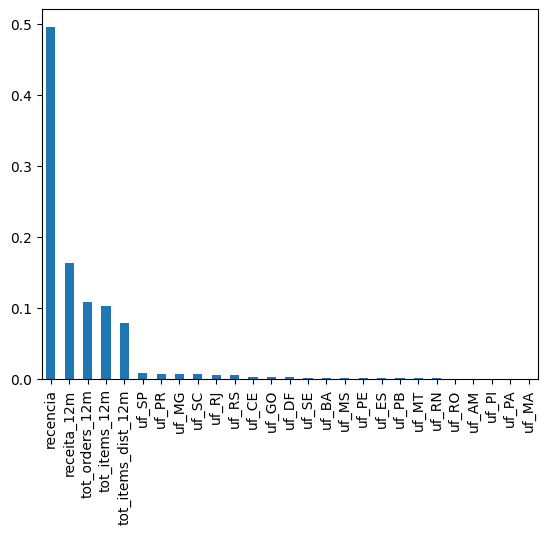

In [19]:
feature_names = melhor_modelo_otimizado.best_estimator_[:-1].transform(X_train).columns
forest_importances = pd.Series(melhor_modelo_otimizado.best_estimator_[-1].feature_importances_, index=feature_names)
forest_importances.sort_values(ascending=False).plot.bar()

## Feature Selection - RFE

In [20]:
from sklearn.feature_selection import RFE

In [21]:
melhor_modelo_otimizado.best_params_

{'random_forest__n_estimators': 300,
 'random_forest__max_features': 'log2',
 'random_forest__max_depth': 15,
 'random_forest__class_weight': None}

In [22]:
clf = RandomForestClassifier(random_state=random_state, n_estimators=300, max_features='log2', max_depth=15, class_weight=None)

steps = (
        steps_em_comum +
        [('rfe', RFE(estimator=clf, n_features_to_select=6))] +
        [('random_forest', clf)]
)

In [23]:
melhor_modelo_otimizado_rfe = Pipeline(steps=steps)
melhor_modelo_otimizado_rfe.fit(X_train, y_train)

Pipeline(steps=[('numeric_imputer',
                 MeanMedianImputer(variables=['tot_orders_12m', 'tot_items_12m',
                                              'tot_items_dist_12m',
                                              'receita_12m', 'recencia'])),
                ('categoric_imputer', CategoricalImputer(variables=['uf'])),
                ('one_hot_encoder', OneHotEncoder(variables=['uf'])),
                ('rfe',
                 RFE(estimator=RandomForestClassifier(max_depth=15,
                                                      max_features='log2',
                                                      n_estimators=300,
                                                      random_state=42),
                     n_features_to_select=6)),
                ('random_forest',
                 RandomForestClassifier(max_depth=15, max_features='log2',
                                        n_estimators=300, random_state=42))])

In [24]:
y_proba_oot = melhor_modelo_otimizado_rfe.predict_proba(X_oot)[:,1]

In [25]:
roc_auc_oot = roc_auc_score(y_oot, y_proba_oot)
print(f'RoC-AUC: {roc_auc_oot:.6f}')

RoC-AUC: 0.917590


## Avaliando o melhor modelo

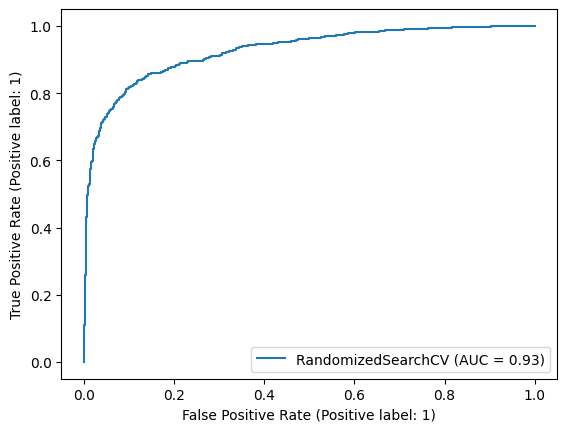

In [26]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(melhor_modelo_otimizado, X_oot, y_oot);

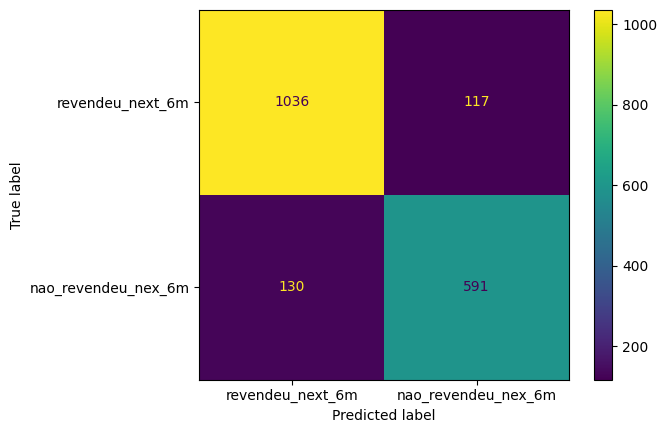

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(melhor_modelo_otimizado, X_oot, y_oot, values_format='d', display_labels=['revendeu_next_6m', 'nao_revendeu_nex_6m'])

In [28]:
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score

In [29]:
y_pred_oot = melhor_modelo_otimizado.predict(X_oot)

In [30]:
print(classification_report(y_oot, y_pred_oot))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1153
           1       0.83      0.82      0.83       721

    accuracy                           0.87      1874
   macro avg       0.86      0.86      0.86      1874
weighted avg       0.87      0.87      0.87      1874



In [31]:
print(f'Acurácia OOT: {accuracy_score(y_oot, y_pred_oot):.4f}')
print(f'Acurácia Balanceada OOT: {balanced_accuracy_score(y_oot, y_pred_oot):.4f}')

Acurácia OOT: 0.8682
Acurácia Balanceada OOT: 0.8591


In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_oot, y_pred_oot)

array([[1036,  117],
       [ 130,  591]])

In [33]:
true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_oot, y_pred_oot).ravel()

In [34]:
comissao_12m = (
    df_train
    .query('nao_revendeu_next_6m == 1')
    .assign(comissao_12m = lambda df: df['receita_12m'] * 0.10)
    .filter(['comissao_12m'])
    .mean()
).iloc[0].round()

comissao_12m

110.0

In [35]:
false_class = true_negative + false_positive
true_class = false_negative + true_positive

comissao = 110
valor_cupom = 100

total_comissao_perdida = (true_class * comissao )
economia_bruta = (total_comissao_perdida) - (false_negative * comissao)
custo_atuacao_modelo = (true_positive + false_positive) * valor_cupom
economia_efetiva = economia_bruta - custo_atuacao_modelo
economia_efetiva

-5790

## Salvando o melhor modelo

In [36]:
!pip install joblib

In [37]:
import joblib

In [38]:
!mkdir '/content/drive/MyDrive/modelos'

mkdir: cannot create directory ‘/content/drive/MyDrive/modelos’: File exists


In [39]:
import datetime

date = datetime.datetime.now().strftime("%Y%m%d")
date

'20240120'

In [40]:
caminho = f'/content/drive/MyDrive/modelos/{date}_olist_revenda_melhor_modelo_otimizado.joblib'
joblib.dump(melhor_modelo, caminho)

['/content/drive/MyDrive/modelos/20240120_olist_revenda_melhor_modelo_otimizado.joblib']

# Prevendo em novos dados

## Criando uma nova safra

In [41]:
import pandas as pd

df_orders = pd.read_csv(os.path.join(DATA_DIR, 'olist_orders_dataset.csv'), parse_dates=['order_approved_at'])
df_order_items = pd.read_csv(os.path.join(DATA_DIR, 'olist_order_items_dataset.csv'))
df_sellers = pd.read_csv(os.path.join(DATA_DIR, 'olist_sellers_dataset.csv'))


import dateutil

data_ref_safra     = pd.to_datetime('2018-04-01').date()
data_inf_inclusiva = data_ref_safra - dateutil.relativedelta.relativedelta(months=12)

df_producao = (

    # juntando as tabelas e filtrando o período
    df_order_items
    .merge(df_orders, on='order_id', how='inner')
    .query('order_status == "delivered"')
    .query(f'order_approved_at >= "{data_inf_inclusiva}" & order_approved_at < "{data_ref_safra}"')
    .merge(df_sellers, on='seller_id', how='left')

    # construindo as features
    .groupby('seller_id')
    .agg(uf                 = ('seller_state', 'first'),
        tot_orders_12m     = ('order_id', 'nunique'),
        tot_items_12m      = ('product_id', 'count'),
        tot_items_dist_12m = ('product_id', 'nunique'),
        receita_12m        = ('price', 'sum'),
        data_ult_vnd       = ('order_approved_at', 'max'))
    .reset_index()
    .assign(data_ref_safra = pd.to_datetime(f'{data_ref_safra}'))
    .assign(recencia = lambda df: (df['data_ref_safra'] - df['data_ult_vnd']).dt.days)
    .filter(['data_ref_safra', 'seller_id', 'uf', 'tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m', 'recencia'])
)

df_producao

,data_ref_safra,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia
0,2018-04-01,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,3,1,2685.00,164
1,2018-04-01,001cca7ae9ae17fb1caed9dfb1094831,ES,171,195,10,20321.53,0
2,2018-04-01,002100f778ceb8431b7a1020ff7ab48f,SP,48,52,23,1106.80,4
3,2018-04-01,003554e2dce176b5555353e4f3555ac8,GO,1,1,1,120.00,106
4,2018-04-01,004c9cd9d87a3c30c522c48c4fc07416,SP,126,131,65,14685.67,5
...,...,...,...,...,...,...,...,...
1936,2018-04-01,ffad1e7127fb622cb64a900751590acd,SP,1,2,1,35.60,18
1937,2018-04-01,ffc470761de7d0232558ba5e786e57b7,SP,6,7,6,555.57,25
1938,2018-04-01,ffdd9f82b9a447f6f8d4b91554cc7dd3,PR,10,11,8,1350.30,38
1939,2018-04-01,ffeee66ac5d5a62fe688b9d26f83f534,SP,13,13,3,1709.87,31


**Perceba que não temos o target, pois essa base é de produção (evento de interesse ainda não ocorreu).**

In [42]:
key_vars = ['data_ref_safra', 'seller_id']
num_vars = ['tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m', 'recencia']
cat_vars = ['uf']

features = cat_vars + num_vars

X_producao = df_producao[features]

## Carregando o modelo

In [43]:
import joblib

date = '20240120'
model_path = f'/content/drive/MyDrive/modelos/{date}_olist_revenda_melhor_modelo_otimizado.joblib'
model = joblib.load(model_path)
model

Pipeline(steps=[('numeric_imputer',
                 MeanMedianImputer(variables=['tot_orders_12m', 'tot_items_12m',
                                              'tot_items_dist_12m',
                                              'receita_12m', 'recencia'])),
                ('categoric_imputer', CategoricalImputer(variables=['uf'])),
                ('one_hot_encoder', OneHotEncoder(variables=['uf'])),
                ('random_forest', RandomForestClassifier(random_state=42))])

## Realizando as predições

In [44]:
X_producao.head(3)

,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia
0,SP,3,3,1,2685.00,164
1,ES,171,195,10,20321.53,0
2,SP,48,52,23,1106.80,4


In [45]:
y_pred_producao = model.predict(X_producao)
y_proba_producao_1 = model.predict_proba(X_producao)[:, 1]
y_proba_producao_0 = model.predict_proba(X_producao)[:, 0]

In [46]:
df_producao = df_producao.assign(classe_prevista = y_pred_producao)
df_producao = df_producao.assign(score_1 = y_proba_producao_1)
df_producao = df_producao.assign(score_0 = y_proba_producao_0)
df_producao

,data_ref_safra,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,classe_prevista,score_1,score_0
0,2018-04-01,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,3,1,2685.00,164,1,0.69,0.31
1,2018-04-01,001cca7ae9ae17fb1caed9dfb1094831,ES,171,195,10,20321.53,0,0,0.01,0.99
2,2018-04-01,002100f778ceb8431b7a1020ff7ab48f,SP,48,52,23,1106.80,4,0,0.12,0.88
3,2018-04-01,003554e2dce176b5555353e4f3555ac8,GO,1,1,1,120.00,106,1,0.71,0.29
4,2018-04-01,004c9cd9d87a3c30c522c48c4fc07416,SP,126,131,65,14685.67,5,0,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...
1936,2018-04-01,ffad1e7127fb622cb64a900751590acd,SP,1,2,1,35.60,18,0,0.22,0.78
1937,2018-04-01,ffc470761de7d0232558ba5e786e57b7,SP,6,7,6,555.57,25,0,0.09,0.91
1938,2018-04-01,ffdd9f82b9a447f6f8d4b91554cc7dd3,PR,10,11,8,1350.30,38,0,0.04,0.96
1939,2018-04-01,ffeee66ac5d5a62fe688b9d26f83f534,SP,13,13,3,1709.87,31,0,0.16,0.84


## Monitoramento de modelos

**Como saber se o modelo irá performar bem ou não em novos dados?**

- Esperar passar os 6 meses a partir do dia 2018-04-01 e calcular a métrica de interesse.

- Verificar se a distribuição da predição/score mudou na base nova (produção) em relação a base de treinamento (referência). Quando existe uma mudança de distribuição da variável, dizemos que ocorreu um **drift**.

Na primeira opção temos um monitoramento reativo, pois esperamos o evento acontecer para poder calcular o desempenho do modelo.

Geralmente essa opção não é interessante, pois em termos de negócios o ideal é atuarmos antes do modelo perder o desempenho, ou seja, de forma preventiva. A segunda opção é uma forma de se fazer isso.

Para implementarmos a segunda opção, iremos utilizar uma biblioteca do Python chamada [Evidently](https://github.com/evidentlyai/evidently).

In [47]:
!pip install evidently

In [48]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

In [49]:
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

In [50]:
df_referencia = pd.read_csv(os.path.join(DATA_DIR, 'propensao_revenda_abt.csv'))
df_referencia['classe_prevista'] = model.predict(df_referencia[features])
df_referencia['score_0'] = model.predict_proba(df_referencia[features])[:, 0]
df_referencia['score_1'] = model.predict_proba(df_referencia[features])[:, 1]

X_referencia = df_referencia[features + ['classe_prevista', 'score_1', 'score_0']]
X_referencia.head(3)

,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,classe_prevista,score_1,score_0
0,SP,3,3,1,2685.00,74,1,0.77,0.23
1,ES,171,207,9,21275.23,2,0,0.01,0.99
2,SP,38,42,15,781.80,2,0,0.03,0.97


In [51]:
X_producao = df_producao.iloc[:, 2:]
X_producao.head(3)

,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,classe_prevista,score_1,score_0
0,SP,3,3,1,2685.00,164,1,0.69,0.31
1,ES,171,195,10,20321.53,0,0,0.01,0.99
2,SP,48,52,23,1106.80,4,0,0.12,0.88


In [52]:
data_drift_report.run(current_data=X_producao, reference_data=X_referencia, column_mapping=None)
data_drift_report

Output hidden; open in https://colab.research.google.com to view.

No relatório, podemos olhar diretamente na variável `score` contém algum **drift** previsto pelo modelo.

Se não existe **drift** no `score` existe um forte indicativo de que o modelo irá manter a estabilidade e não haverá uma perda de desempenho na nova safra (produção).

Porém se existir **drift** no `score` então é importante olhar quais as `features` apresentam os maiores **drift**, pois essas features provavelmente serão as maiores responsáveis pela perda de estabilidade e performance do modelo.

Neste caso, uma boa ação a ser tomada é o re-treinamento do modelo com novos dados (se disponível).

No nosso caso, não identificamos **drif** na predição do modelo. Logo, podemos esperar que o nosso modelo não irá perder desempenho ao longo do tempo e manterá a sua estabilidade (assim se espera).